# AirBnB data cleaning

## Notebook set-up

Assume we are preparing this data for a linear regression model.

In [1]:
# PyPI imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor

import gperdrizet_functions as funcs

pd.set_option('display.max_rows', 500)

## 1. Data loading

In [2]:
data_df=pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/data-preprocessing-project-tutorial/main/AB_NYC_2019.csv')
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

## 2. Feature selection

In [3]:
label='price'

features=[
    'latitude',
    'longitude',
    'minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'calculated_host_listings_count',
    'availability_365',
    'neighbourhood_group',
    'room_type'
]

numerical_features=[
    'price',
    'latitude',
    'longitude',
    'minimum_nights',
    'number_of_reviews',
    'reviews_per_month',
    'calculated_host_listings_count',
    'availability_365'
]

categorical_features=['neighbourhood_group','room_type']

data_df=data_df[numerical_features + categorical_features].copy()

## 3. Feature encoding

In [4]:
encoding_datasets={}

### 3.1. Label encoding

In [5]:
label_encoders={}
label_encoded_data_df=data_df.copy()

for feature in categorical_features:
    label_encoder=LabelEncoder()
    label_encoded_data_df[feature]=label_encoder.fit_transform(label_encoded_data_df[feature])
    label_encoders[feature]=label_encoder

encoding_datasets['Label encoded']=label_encoded_data_df

label_encoded_data_df.head().transpose()

,0,1,2,3,4
price,149.00000,225.00000,150.00000,89.00000,80.00000
latitude,40.64749,40.75362,40.80902,40.68514,40.79851
longitude,-73.97237,-73.98377,-73.94190,-73.95976,-73.94399
minimum_nights,1.00000,1.00000,3.00000,1.00000,10.00000
number_of_reviews,9.00000,45.00000,0.00000,270.00000,9.00000
reviews_per_month,0.21000,0.38000,NaN,4.64000,0.10000
calculated_host_listings_count,6.00000,2.00000,1.00000,1.00000,1.00000
availability_365,365.00000,355.00000,365.00000,194.00000,0.00000
neighbourhood_group,1.00000,2.00000,2.00000,1.00000,2.00000
room_type,1.00000,0.00000,1.00000,0.00000,0.00000


### 3.2. One-hot encoding

In [6]:
one_hot_encoder=OneHotEncoder(sparse_output=False)
one_hot_encoded_data=one_hot_encoder.fit_transform(data_df[categorical_features])
one_hot_encoded_data_df=pd.DataFrame(one_hot_encoded_data, columns=one_hot_encoder.get_feature_names_out())
one_hot_encoded_data_df=pd.concat([one_hot_encoded_data_df, data_df[numerical_features]], axis=1)
encoding_datasets['One-hot encoded']=one_hot_encoded_data_df

one_hot_encoded_data_df.head().transpose()

,0,1,2,3,4
neighbourhood_group_Bronx,0.00000,0.00000,0.00000,0.00000,0.00000
neighbourhood_group_Brooklyn,1.00000,0.00000,0.00000,1.00000,0.00000
neighbourhood_group_Manhattan,0.00000,1.00000,1.00000,0.00000,1.00000
neighbourhood_group_Queens,0.00000,0.00000,0.00000,0.00000,0.00000
neighbourhood_group_Staten Island,0.00000,0.00000,0.00000,0.00000,0.00000
room_type_Entire home/apt,0.00000,1.00000,0.00000,1.00000,1.00000
room_type_Private room,1.00000,0.00000,1.00000,0.00000,0.00000
room_type_Shared room,0.00000,0.00000,0.00000,0.00000,0.00000
price,149.00000,225.00000,150.00000,89.00000,80.00000
latitude,40.64749,40.75362,40.80902,40.68514,40.79851


### 3.3. Results

### 3.3.1. Linear model

In [7]:
linear_results_df=funcs.test_features(LinearRegression(), encoding_datasets, label, scoring='neg_root_mean_squared_error')

data=[list(x) for _, x in linear_results_df.groupby('Feature set')['Score']]
labels=[[x]*len(y) for x, y in linear_results_df.groupby('Feature set')['Score']]
results=kruskal(*data)
print(f'Kruskal-Wallis p-value: {results.pvalue:.3f}\n')

linear_result=pairwise_tukeyhsd(np.concatenate(data), np.concatenate(labels), alpha=0.05)

Kruskal-Wallis p-value: 0.595



### 3.3.2. Tree model

In [8]:
tree_results_df=funcs.test_features(HistGradientBoostingRegressor(random_state=315), encoding_datasets, label, scoring='neg_root_mean_squared_error')

data=[list(x) for _, x in tree_results_df.groupby('Feature set')['Score']]
labels=[[x]*len(y) for x, y in tree_results_df.groupby('Feature set')['Score']]
results=kruskal(*data)
print(f'Kruskal-Wallis p-value: {results.pvalue:.3f}\n')

tree_result=pairwise_tukeyhsd(np.concatenate(data), np.concatenate(labels), alpha=0.05)

Kruskal-Wallis p-value: 0.953



### 3.3.3. Model comparison

Linear model:
         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2     meandiff p-adj   lower    upper  reject
---------------------------------------------------------------------
Label encoded One-hot encoded  -1.2177 0.8534 -14.3494 11.9139  False
---------------------------------------------------------------------

Tree model:
         Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2     meandiff p-adj   lower    upper  reject
---------------------------------------------------------------------
Label encoded One-hot encoded   0.1353 0.9822 -11.9596 12.2303  False
---------------------------------------------------------------------


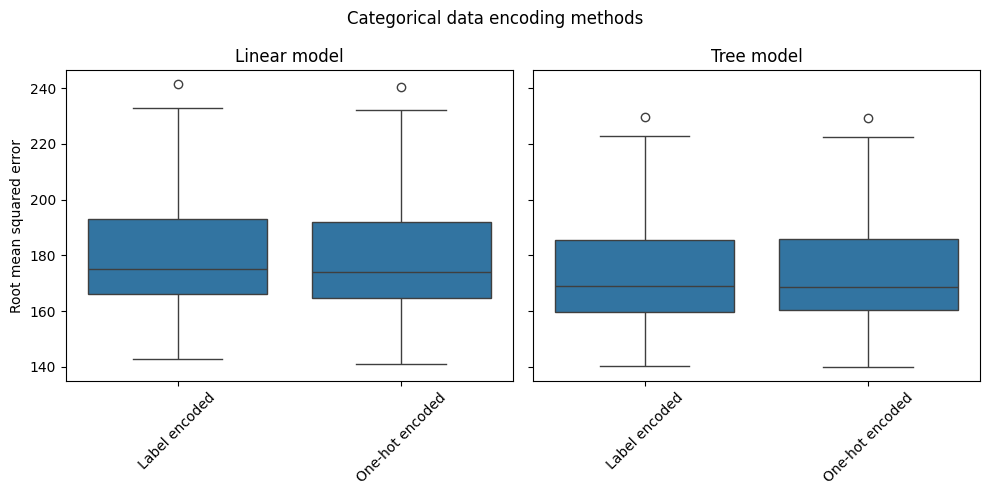

In [9]:
print(f'Linear model:\n{linear_result}\n')
print(f'Tree model:\n{tree_result}')

fig, axs=plt.subplots(1,2, figsize=(10,5), sharey=True)
axs=axs.flatten()

fig.suptitle('Categorical data encoding methods')

sns.boxplot(linear_results_df, x='Feature set', y='Score', ax=axs[0])
axs[0].set_title('Linear model')
axs[0].set_xlabel('')
axs[0].tick_params(axis='x', labelrotation=45)
axs[0].set_ylabel('Root mean squared error')

sns.boxplot(tree_results_df, x='Feature set', y='Score', ax=axs[1])
axs[1].set_title('Tree model')
axs[1].set_xlabel('')
axs[1].tick_params(axis='x', labelrotation=45)
axs[1].set_ylabel('Root mean squared error')

plt.tight_layout()
plt.show()

## 4. Missing data

In [10]:
nan_cleaned_datasets={}
encoded_data_df=label_encoded_data_df.copy()
encoded_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 10 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   price                           48895 non-null  int64  
 1   latitude                        48895 non-null  float64
 2   longitude                       48895 non-null  float64
 3   minimum_nights                  48895 non-null  int64  
 4   number_of_reviews               48895 non-null  int64  
 5   reviews_per_month               38843 non-null  float64
 6   calculated_host_listings_count  48895 non-null  int64  
 7   availability_365                48895 non-null  int64  
 8   neighbourhood_group             48895 non-null  int64  
 9   room_type                       48895 non-null  int64  
dtypes: float64(3), int64(7)
memory usage: 3.7 MB


### 4.1. Drop reviews per month

In [11]:
nan_cleaned_datasets['-reviews_per_month']=encoded_data_df.drop('reviews_per_month', axis=1).dropna()

### 4.2. Drop NAN rows

In [12]:
nan_cleaned_datasets['Dropped']=encoded_data_df.dropna()
print(f"Reviews per month mean: {nan_cleaned_datasets['Dropped']['reviews_per_month'].mean():.2f}")

Reviews per month mean: 1.37


### 4.2. Fill NAN with median

In [13]:
median_imputer=SimpleImputer(strategy='median')
median_imputed_data=median_imputer.fit_transform(encoded_data_df)
nan_cleaned_datasets['Median imputed']=pd.DataFrame(median_imputed_data, columns=encoded_data_df.columns)
print(f"Reviews per month mean: {nan_cleaned_datasets['Median imputed']['reviews_per_month'].mean():.2f}")

Reviews per month mean: 1.24


### 4.3. KNN imputation

In [14]:
knn_imputer=KNNImputer()
knn_imputed_data=knn_imputer.fit_transform(encoded_data_df)
nan_cleaned_datasets['KNN imputed']=pd.DataFrame(knn_imputed_data, columns=encoded_data_df.columns)
print(f"Reviews per month mean: {nan_cleaned_datasets['KNN imputed']['reviews_per_month'].mean():.2f}")

Reviews per month mean: 1.18


### 4.3. Results

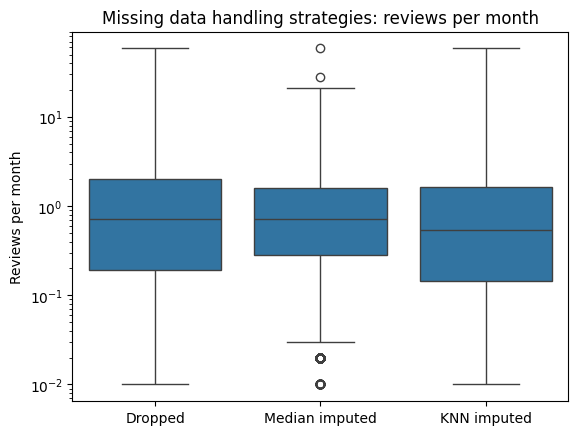

In [15]:
strategy=['Dropped']*len(nan_cleaned_datasets['Dropped']['reviews_per_month']) + ['Median imputed']*len(nan_cleaned_datasets['Median imputed']['reviews_per_month']) + ['KNN imputed']*len(nan_cleaned_datasets['KNN imputed']['reviews_per_month'])
reviews_per_month=nan_cleaned_datasets['Dropped']['reviews_per_month'].to_list() + nan_cleaned_datasets['Median imputed']['reviews_per_month'].to_list() + nan_cleaned_datasets['KNN imputed']['reviews_per_month'].to_list()

reviews_per_month_df=pd.DataFrame.from_dict(
    {
        'Strategy':strategy,
        'Reviews per month':reviews_per_month
    }
)

sns.boxplot(reviews_per_month_df, x='Strategy', y='Reviews per month', log_scale=True)
plt.title('Missing data handling strategies: reviews per month')
plt.xlabel('')
plt.show()

#### 4.3.1. Linear model

In [16]:
linear_results_df=funcs.test_features(LinearRegression(), nan_cleaned_datasets, label, scoring='neg_root_mean_squared_error')

data=[list(x) for _, x in linear_results_df.groupby('Feature set')['Score']]
labels=[[x]*len(y) for x, y in linear_results_df.groupby('Feature set')['Score']]
results=kruskal(*data)
print(f'Kruskal-Wallis p-value: {results.pvalue:.3f}\n')

linear_result=pairwise_tukeyhsd(np.concatenate(data), np.concatenate(labels), alpha=0.05)

Kruskal-Wallis p-value: 0.000



#### 4.3.2. Tree model

In [17]:
tree_results_df=funcs.test_features(HistGradientBoostingRegressor(random_state=315), nan_cleaned_datasets, label, scoring='neg_root_mean_squared_error')

data=[list(x) for _, x in linear_results_df.groupby('Feature set')['Score']]
labels=[[x]*len(y) for x, y in linear_results_df.groupby('Feature set')['Score']]
results=kruskal(*data)
print(f'Kruskal-Wallis p-value: {results.pvalue:.3f}\n')

tree_result=pairwise_tukeyhsd(np.concatenate(data), np.concatenate(labels), alpha=0.05)

Kruskal-Wallis p-value: 0.000



#### 4.3.3. Model comparison

Linear model:
           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
      group1           group2     meandiff p-adj  lower    upper   reject
-------------------------------------------------------------------------
-reviews_per_month        Dropped -46.7857   0.0 -66.2186 -27.3529   True
-reviews_per_month    KNN imputed  -0.0029   1.0 -19.4357    19.43  False
-reviews_per_month Median imputed   0.0049   1.0 -19.4279  19.4378  False
           Dropped    KNN imputed  46.7829   0.0    27.35  66.2158   True
           Dropped Median imputed  46.7907   0.0  27.3578  66.2235   True
       KNN imputed Median imputed   0.0078   1.0 -19.4251  19.4407  False
-------------------------------------------------------------------------

Tree model:
           Multiple Comparison of Means - Tukey HSD, FWER=0.05           
      group1           group2     meandiff p-adj  lower    upper   reject
-------------------------------------------------------------------------
-reviews_pe

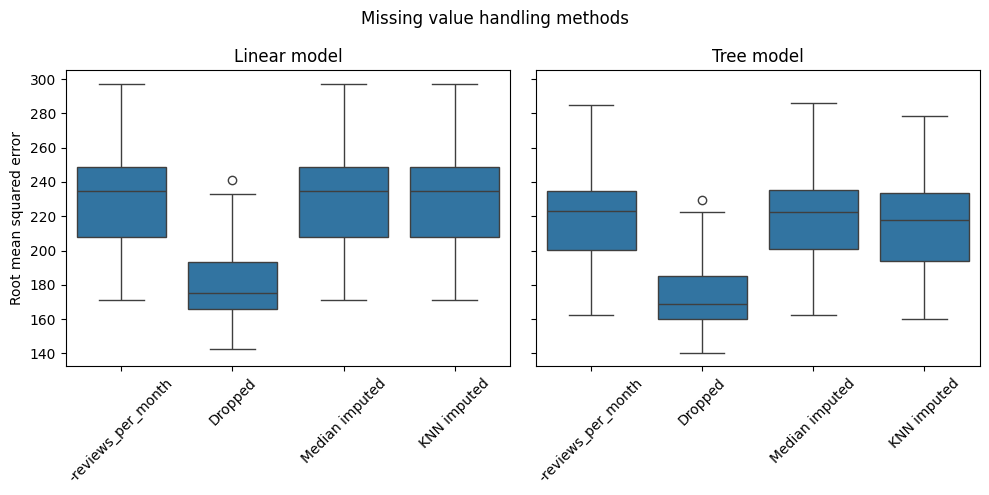

In [18]:
print(f'Linear model:\n{linear_result}\n')
print(f'Tree model:\n{tree_result}')

fig, axs=plt.subplots(1,2, figsize=(10,5), sharey=True)
axs=axs.flatten()

fig.suptitle('Missing value handling methods')

sns.boxplot(linear_results_df, x='Feature set', y='Score', ax=axs[0])
axs[0].set_title('Linear model')
axs[0].set_xlabel('')
axs[0].tick_params(axis='x', labelrotation=45)
axs[0].set_ylabel('Root mean squared error')

sns.boxplot(tree_results_df, x='Feature set', y='Score', ax=axs[1])
axs[1].set_title('Tree model')
axs[1].set_xlabel('')
axs[1].tick_params(axis='x', labelrotation=45)
axs[1].set_ylabel('Root mean squared error')

plt.tight_layout()
plt.show()

## 5. Extreme values

In [19]:
datasets={}
data_df=pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/data-preprocessing-project-tutorial/main/AB_NYC_2019.csv')
data_df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


### 5.1. Clean hosts

In [ ]:
institutional_hosts=['Blueground','Sonder (NYC)','Sonder', 'Row NYC', 'Corporate Housing']

hosts_cleaned_df=data_df.copy()
hosts_cleaned_df=data_df[~data_df['host_name'].isin(institutional_hosts)]
datasets['Hosts cleaned']=hosts_cleaned_df[numerical_features + categorical_features].copy()

hosts_cleaned_df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.814000e+04,4.814000e+04,48140.000000,48140.00000,48140.000000,48140.000000,48140.000000,38494.000000,48140.000000,48140.000000
mean,1.884743e+07,6.648550e+07,40.728894,-73.95151,151.195430,6.779269,23.596386,1.371510,3.551600,110.215372
std,1.096050e+07,7.809557e+07,0.054870,0.04617,241.396545,20.493203,44.814217,1.652251,11.060121,130.574084
min,2.539000e+03,2.438000e+03,40.499790,-74.24442,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.365101e+06,7.599467e+06,40.689667,-73.98239,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.943935e+07,3.028359e+07,40.722955,-73.95517,104.000000,2.000000,5.000000,0.710000,1.000000,41.000000
75%,2.887456e+07,1.050638e+08,40.763452,-73.93561,175.000000,5.000000,24.000000,2.020000,2.000000,218.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.71299,10000.000000,1250.000000,629.000000,20.940000,121.000000,365.000000


### 5.2. Clip price

In [ ]:
price_clipped_df=data_df.copy()
price_clipped_df['price']=price_clipped_df['price'].clip(upper=5000)
datasets['Price clipped']=price_clipped_df[numerical_features + categorical_features].copy()
price_clipped_df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,151.610778,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,206.682511,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,5000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


### 5.3. Clip price and clean hosts

In [ ]:
price_clipped_host_cleaned_df=data_df.copy()
price_clipped_host_cleaned_df['price']=price_clipped_host_cleaned_df['price'].clip(upper=5000)
price_clipped_host_cleaned_df=price_clipped_host_cleaned_df[~price_clipped_host_cleaned_df['host_name'].isin(institutional_hosts)]
datasets['Hosts cleaned, price clipped']=price_clipped_host_cleaned_df[numerical_features + categorical_features].copy()
price_clipped_host_cleaned_df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.814000e+04,4.814000e+04,48140.000000,48140.00000,48140.000000,48140.000000,48140.000000,38494.000000,48140.000000,48140.000000
mean,1.884743e+07,6.648550e+07,40.728894,-73.95151,150.068114,6.779269,23.596386,1.371510,3.551600,110.215372
std,1.096050e+07,7.809557e+07,0.054870,0.04617,207.552153,20.493203,44.814217,1.652251,11.060121,130.574084
min,2.539000e+03,2.438000e+03,40.499790,-74.24442,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.365101e+06,7.599467e+06,40.689667,-73.98239,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.943935e+07,3.028359e+07,40.722955,-73.95517,104.000000,2.000000,5.000000,0.710000,1.000000,41.000000
75%,2.887456e+07,1.050638e+08,40.763452,-73.93561,175.000000,5.000000,24.000000,2.020000,2.000000,218.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.71299,5000.000000,1250.000000,629.000000,20.940000,121.000000,365.000000


### 5.4. Encode and impute cleaned datasets

In [23]:
for dataset, data_df in datasets.items():

    for feature in categorical_features:
        label_encoder=LabelEncoder()
        data_df[feature]=label_encoder.fit_transform(data_df[feature])

    knn_imputer=KNNImputer()
    data_df[numerical_features]=knn_imputer.fit_transform(data_df[numerical_features])
    datasets[dataset]=data_df

datasets['Raw']=nan_cleaned_datasets['KNN imputed']

/tmp/ipykernel_531653/1990562678.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df[feature]=label_encoder.fit_transform(data_df[feature])
/tmp/ipykernel_531653/1990562678.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df[feature]=label_encoder.fit_transform(data_df[feature])
/tmp/ipykernel_531653/1990562678.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

### 5.5. Results

#### 5.5.1. Linear model

In [24]:
linear_results_df=funcs.test_features(LinearRegression(), datasets, label, scoring='neg_root_mean_squared_error')

data=[list(x) for _, x in linear_results_df.groupby('Feature set')['Score']]
labels=[[x]*len(y) for x, y in linear_results_df.groupby('Feature set')['Score']]
results=kruskal(*data)
print(f'Kruskal-Wallis p-value: {results.pvalue:.3f}\n')

linear_result=pairwise_tukeyhsd(np.concatenate(data), np.concatenate(labels), alpha=0.05)

Kruskal-Wallis p-value: 0.000



#### 5.5.2. Tree model

In [ ]:
tree_results_df=funcs.test_features(HistGradientBoostingRegressor(random_state=315), datasets, label, scoring='neg_root_mean_squared_error')

data=[list(x) for _, x in linear_results_df.groupby('Feature set')['Score']]
labels=[[x]*len(y) for x, y in linear_results_df.groupby('Feature set')['Score']]
results=kruskal(*data)
print(f'Kruskal-Wallis p-value: {results.pvalue:.3f}\n')

tree_result=pairwise_tukeyhsd(np.concatenate(data), np.concatenate(labels), alpha=0.05)

Kruskal-Wallis p-value: 0.000



#### 5.5.3. Model comparison

Linear model:
                       Multiple Comparison of Means - Tukey HSD, FWER=0.05                        
           group1                       group2            meandiff p-adj   lower    upper   reject
--------------------------------------------------------------------------------------------------
               Hosts cleaned Hosts cleaned, price clipped -36.2846    0.0 -50.9467 -21.6224   True
               Hosts cleaned                Price clipped -35.0989    0.0  -49.761 -20.4367   True
               Hosts cleaned                          Raw  -0.2216    1.0 -14.8838  14.4406  False
Hosts cleaned, price clipped                Price clipped   1.1857 0.9967 -13.4765  15.8479  False
Hosts cleaned, price clipped                          Raw   36.063    0.0  21.4008  50.7251   True
               Price clipped                          Raw  34.8773    0.0  20.2151  49.5394   True
-----------------------------------------------------------------------------------------------

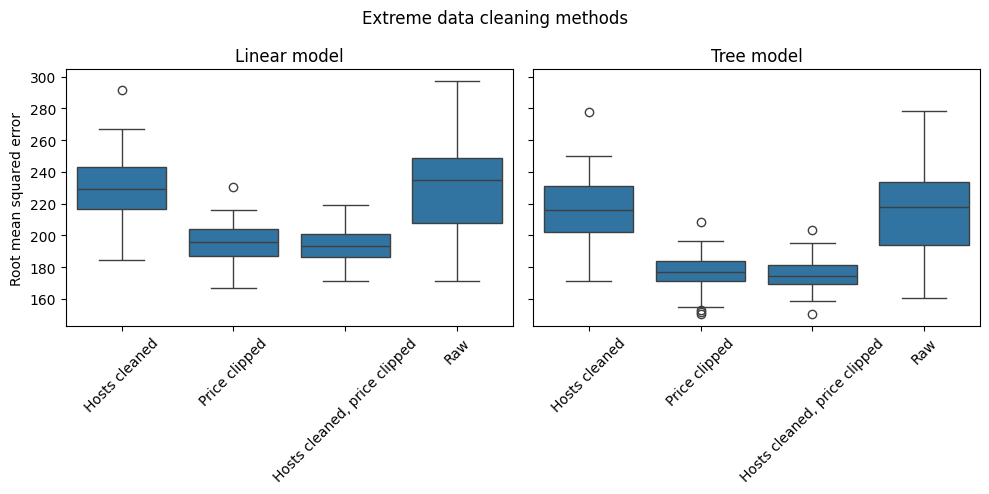

In [26]:
print(f'Linear model:\n{linear_result}\n')
print(f'Tree model:\n{tree_result}')

fig, axs=plt.subplots(1,2, figsize=(10,5), sharey=True)
axs=axs.flatten()

fig.suptitle('Extreme data cleaning methods')

sns.boxplot(linear_results_df, x='Feature set', y='Score', ax=axs[0])
axs[0].set_title('Linear model')
axs[0].set_xlabel('')
axs[0].tick_params(axis='x', labelrotation=45)
axs[0].set_ylabel('Root mean squared error')

sns.boxplot(tree_results_df, x='Feature set', y='Score', ax=axs[1])
axs[1].set_title('Tree model')
axs[1].set_xlabel('')
axs[1].tick_params(axis='x', labelrotation=45)
axs[1].set_ylabel('Root mean squared error')

plt.tight_layout()
plt.show()

## 6. Save cleaned data

In [31]:
datasets['Hosts cleaned, price clipped'].head()

,price,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,neighbourhood_group,room_type
0,149.0,40.64749,-73.97237,1.0,9.0,0.210,6.0,365.0,1,1
1,225.0,40.75362,-73.98377,1.0,45.0,0.380,2.0,355.0,2,0
2,150.0,40.80902,-73.94190,3.0,0.0,0.282,1.0,365.0,2,1
3,89.0,40.68514,-73.95976,1.0,270.0,4.640,1.0,194.0,1,0
4,80.0,40.79851,-73.94399,10.0,9.0,0.100,1.0,0.0,2,0


In [32]:
datasets['Hosts cleaned, price clipped'].to_parquet('./data/processed/gperdrizet_cleaned_data.parquet')